In [1]:
import pandas as pd
import numpy as np

def get_time_series_for_window(start_date, end_date, station, dataframe):
    return dataframe.loc[start_date:end_date, [station]]


def check_nan_values(dataframe):
    return dataframe.isnull().values.any()


def get_valid_sequences(df):
    valid_sequences = []
    starting_idx = 0

    for i, (_, row) in enumerate(df.iterrows()):
        flow = row[0]

        if np.isnan(flow):

            if starting_idx < i-1:
                valid_sequences.append((starting_idx, i))
                starting_idx = i+1
            else:
                starting_idx = i+1
                continue
    
    if not check_nan_values(df.iloc[starting_idx:, :]):
        valid_sequences.append((starting_idx, len(df)))
    return valid_sequences


def valid_seqs_minimum_len(valid_seqs, seq_len):
    
    valid_seqs_min_len = []
    pops = []
    for i, (start, end) in enumerate(valid_seqs):
        if end - start >= seq_len:
            valid_seqs_min_len.append((start, end))

    return valid_seqs_min_len



def split_sequences(possible_seqs, split_len):
    
    usable_seqs = []
    for seq in possible_seqs:
        usable_seqs += get_seq_splits(seq, split_len)
        
    return usable_seqs
        
        
        
def get_seq_splits(seq, split_len):
    
    start = seq[0]
    end = seq[1]
    
    chunks = (end - start) // (split_len+1)     # +1 because there must be an unobserved item after each chunk
                                                # which will be the y (after window value)

    splits = []
    prev_end_chunk = start
    for i in range(chunks):

        start_chunk = prev_end_chunk
        end_chunk = start_chunk + split_len
        splits.append((start_chunk, end_chunk))
        prev_end_chunk = end_chunk+1
        
    return splits


def get_seq_obs_values(seq, df):
    return np.array(df.iloc[seq[0]:seq[1], :]), np.array(df.iloc[seq[1], :])


def split_seqs_train_test(train_frac, usable_seqs):
    
    total_seqs = len(usable_seqs)
    train_amount = round(total_seqs * train_frac)
    
    random.shuffle(usable_seqs)
    train_seqs = usable_seqs[0:train_amount]
    test_seqs = usable_seqs[train_amount:]
    
    return train_seqs, test_seqs


def mount_trainable_testable_arrays(seqs, df):
    
    x_data = []
    y_data = []
    for seq in seqs:
        x, y = get_seq_obs_values(seq, df)
        x_data.append(x)
        y_data.append(y)
    
    return np.array(x_data), np.array(y_data)



def transform_cleb_df_into_wal_df(cleb_df):
    
    index_names = {}
    for i, (_, row) in enumerate(cleb_df.iterrows()):
        
        year = str(int(row[2]))
        month = str(int(row[1]))
        day = str(int(row[0]))
        hour = str(int(row[3]))
        index_name = year+'-'+month+'-'+day+'-'+hour
        
        index_names[i] = index_name
        
    
    cleb_df.rename(index=index_names)
    cleb_df = cleb_df.drop('day', 1)
    cleb_df = cleb_df.drop('month', 1)
    cleb_df = cleb_df.drop('year', 1)
    cleb_df = cleb_df.drop('hour', 1)
    return cleb_df.replace(-1, np.nan)





flow_path = "/home/colombelli/Documents/hydro-ml/data/Vazao.txt"
rain_path = "/home/colombelli/Documents/hydro-ml/data/Chuva.txt"
et_path = "/home/colombelli/Documents/hydro-ml/data/ET.txt"

flow_df = pd.read_csv(flow_path, sep="\t", header=None)
flow_df.columns = ["day", "month", "year", "hour", "flow"]

rain_df = pd.read_csv(rain_path, sep="\t", header=None)
rain_df.columns = ["day", "month", "year", "hour", "rain"]

et_df = pd.read_csv(et_path, sep="\t", header=None)
et_df.columns = ["day", "month", "year", "hour", "et"]


flow_df = transform_cleb_df_into_wal_df(flow_df)
rain_df = transform_cleb_df_into_wal_df(rain_df)
et_df = transform_cleb_df_into_wal_df(et_df)

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

In [3]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [4]:
dataset = pd.concat([flow_df, rain_df, et_df, flow_df], axis=1)
dataset.columns = ['flow', 'rain', 'et', 'y']

In [86]:
# this fixed val_seq was extracted from the other notebook (no complete automation yet - just a poc)
val_seq = [(5962, 6051), (6078, 17486), (17487, 18718), (18741, 23437)]

#n_steps_in = 24*30   #24 hours, 30 days
#n_steps_out = 24*7   #24 hours, 7 days
n_steps_in = 3 
n_steps_out = 24  

In [87]:
to_split = np.array(dataset.iloc[6078:17486, ])
X, y = split_sequences(to_split, n_steps_in, n_steps_out)

In [88]:
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(200, 
               activation='sigmoid', 
               input_shape=(n_steps_in, n_features)))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [89]:
# fit model
model.fit(X, y, epochs=200, verbose=1)

Epoch 1/200
356/356 [==============================] - 6s 16ms/step - loss: 282374.1875
Epoch 2/200
356/356 [==============================] - 6s 15ms/step - loss: 248343.9688
Epoch 3/200
356/356 [==============================] - 6s 16ms/step - loss: 222445.9375
Epoch 4/200
356/356 [==============================] - 6s 16ms/step - loss: 201566.3125
Epoch 5/200
356/356 [==============================] - 5s 15ms/step - loss: 183766.6250
Epoch 6/200
356/356 [==============================] - 5s 15ms/step - loss: 168760.3750
Epoch 7/200
356/356 [==============================] - 5s 15ms/step - loss: 155982.2188
Epoch 8/200
356/356 [==============================] - 5s 15ms/step - loss: 144853.4062
Epoch 9/200
356/356 [==============================] - 6s 16ms/step - loss: 135072.5938
Epoch 10/200
356/356 [==============================] - 6s 16ms/step - loss: 126287.6875
Epoch 11/200
356/356 [==============================] - 6s 17ms/step - loss: 118173.6641
Epoch 12/200
356/356 [========

356/356 [==============================] - 3s 9ms/step - loss: 14860.2510
Epoch 95/200
356/356 [==============================] - 3s 9ms/step - loss: 14842.4844
Epoch 96/200
356/356 [==============================] - 3s 9ms/step - loss: 14839.9160
Epoch 97/200
356/356 [==============================] - 3s 9ms/step - loss: 14468.6152
Epoch 98/200
356/356 [==============================] - 3s 9ms/step - loss: 14036.1465
Epoch 99/200
356/356 [==============================] - 3s 10ms/step - loss: 14386.5869
Epoch 100/200
356/356 [==============================] - 3s 9ms/step - loss: 14580.5928
Epoch 101/200
356/356 [==============================] - 4s 10ms/step - loss: 14701.8828
Epoch 102/200
356/356 [==============================] - 3s 9ms/step - loss: 14793.1836
Epoch 103/200
356/356 [==============================] - 3s 9ms/step - loss: 14548.2998
Epoch 104/200
356/356 [==============================] - 3s 9ms/step - loss: 14332.9551
Epoch 105/200
356/356 [==========================

356/356 [==============================] - 3s 10ms/step - loss: 12982.1709
Epoch 188/200
356/356 [==============================] - 3s 10ms/step - loss: 12991.6924
Epoch 189/200
356/356 [==============================] - 3s 10ms/step - loss: 12996.5859
Epoch 190/200
356/356 [==============================] - 3s 9ms/step - loss: 13768.9785
Epoch 191/200
356/356 [==============================] - 3s 10ms/step - loss: 13382.1680
Epoch 192/200
356/356 [==============================] - 3s 10ms/step - loss: 12436.0615
Epoch 193/200
356/356 [==============================] - 3s 9ms/step - loss: 13186.0928
Epoch 194/200
356/356 [==============================] - 3s 9ms/step - loss: 13524.5801
Epoch 195/200
356/356 [==============================] - 3s 9ms/step - loss: 13278.7295
Epoch 196/200
356/356 [==============================] - 3s 9ms/step - loss: 13126.8555
Epoch 197/200
356/356 [==============================] - 3s 9ms/step - loss: 12798.7432
Epoch 198/200
356/356 [==================

In [74]:
x_test = np.array(dataset.iloc[17487:18718, 0:3])
y_test = np.array(dataset.iloc[17487:18718, 3:4])

x_test = x_test[0:n_steps_in].reshape((1, n_steps_in, n_features))
yhat = model.predict(x_test, verbose=0)

y_test = y_test[n_steps_in:n_steps_in+n_steps_out]

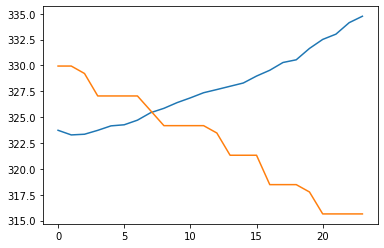

In [75]:
plt.plot(yhat[0])
plt.plot(y_test)

In [76]:
modeled = yhat.flatten()

In [77]:
observed = y_test.flatten()

In [78]:
def get_nash(observed, modeled):
    
    mean_obs = np.mean(observed)
    
    variance = 0 
    squared_err = 0
    for t, obs_flow in enumerate(observed):
        squared_err += (modeled[t] - obs_flow) ** 2
        variance += (obs_flow - mean_obs) ** 2
        
        
    nash = 1 - (squared_err  / variance)
    return nash

In [79]:
get_nash(observed, modeled)

-3.2766338066871663